# **Automatic Cartridge Masking Algorithm**

> Owner: Manthan Patel

> Email: manthankpatel97@gmail.com

* To use this notebook for masking upload pretrained model from the given link (https://drive.google.com/file/d/1YmZH0hATdZgQRhjWclVV3h0A8uVqlMzx/view?usp=drive_link) and upload test images in local session.

## Installing libraries and cloning repository

In [1]:
!pip install mrcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54908 sha256=42ec65c4cd93134ae6d0ad4a45ae2cf6dbd97192af987a0956d104275f3d8fdc
  Stored in directory: /root/.cache/pip/wheels/f6/66/35/4956a489776a1db0ee24e0c33a9088c1b5d68eb5dc2654f0b2
Successfully built mrcnn


In [2]:
# Cloning masking algorithm repository which has required data augmentation and training files
!git clone https://github.com/ManthanKPatel/Automatic_cartridge_masking.git

Cloning into 'Automatic_cartridge_masking'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 2), reused 20 (delta 2), pack-reused 0
Receiving objects: 100% (20/20), 32.38 KiB | 8.09 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [5]:
%cd Automatic_cartridge_masking

/content/Automatic_cartridge_masking


In [6]:
# Importing necessary libraries
import os
import numpy as np
import torch
from PIL import Image

import torchvision
from torchvision.models import MobileNet_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN, FasterRCNN_ResNet50_FPN_Weights, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.rpn import AnchorGenerator


from Automatic_cartridge_masking.references.engine import train_one_epoch, evaluate
import Automatic_cartridge_masking.references.utils
import Automatic_cartridge_masking.references.transforms as T

## Building Model for Results visualisation

In [7]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# replace the classifier with a new one, that has
num_classes = 5  # 4 class (breech face) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=num_classes)

# num_classes which is user-defined
# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).features

# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# # put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=5,  ### 2
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 136MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 71.4MB/s]


In [8]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    # model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print("no.of in features:", in_features)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    print("no.of f mask", in_features_mask)

    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

In [9]:
model = get_model_instance_segmentation(num_classes)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 151MB/s]


no.of in features: 1024
no.of f mask 256


## Loading pretrained model for test image visualisation

In [10]:
# Download pretrained model dictionary from this link: https://drive.google.com/file/d/1YmZH0hATdZgQRhjWclVV3h0A8uVqlMzx/view?usp=drive_link
# Once downloaded upload this file to local session

model.load_state_dict(torch.load("/content/CartridgeMaskRCNN3epoch.pth"))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [11]:
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize= (20,60))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## Test results visualisation

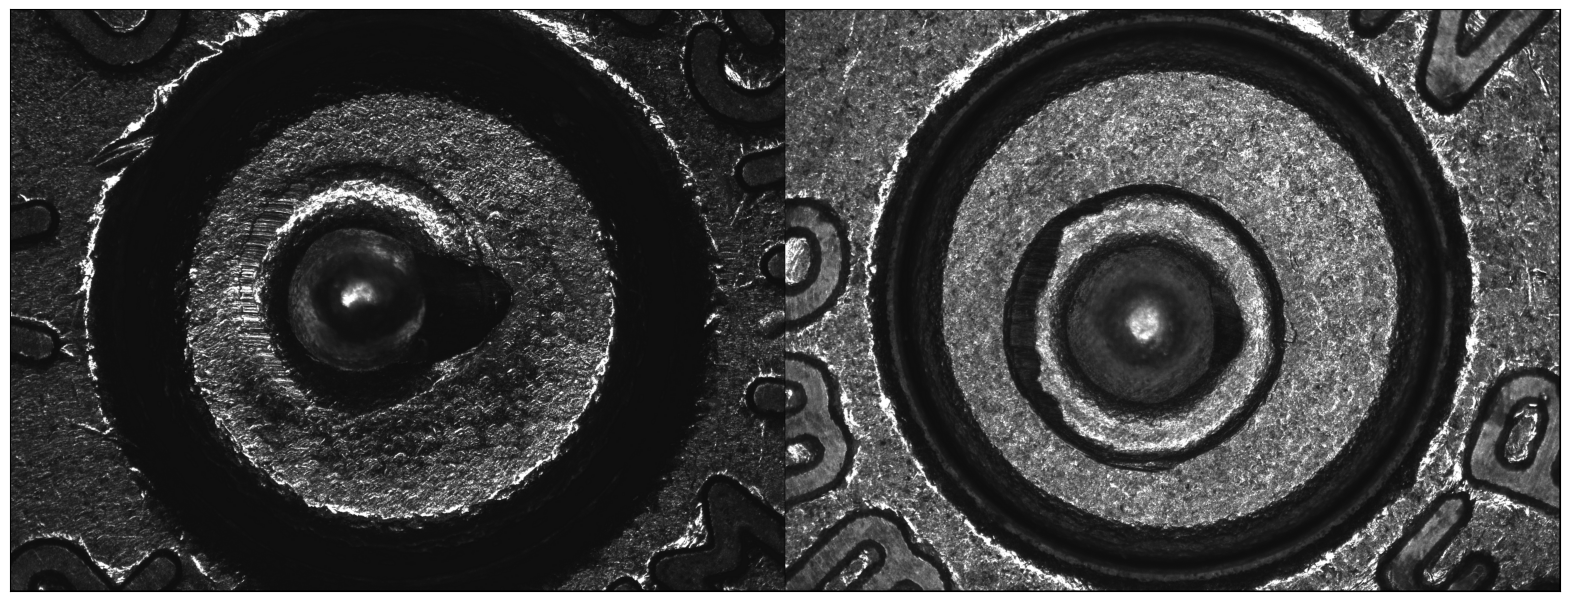

In [13]:
# Loading 2 sample test images
# Upload your test images here and change cartridge_list accordingly

from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

cartridge1_int = read_image(str('/content/NBIDE S BF 029.png'))
cartridge2_int = read_image(str('/content/NBIDE R BF 080.png'))
# cartridge3_int = read_image(str('/content/TWRBF03-05.png'))
cartridge_list = [cartridge1_int, cartridge2_int]

grid = make_grid(cartridge_list)
show(grid)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in cartridge_list]
# images = [transforms(cartridge_int)]


outputs = model(images)

In [16]:
# Label dictionary for reference

label_dict = {'Aperture_shear' : 1,
        'Firing_pin_drag' : 2,
        'Firing_pin_impression' : 3,
        'Breech_face' : 4}

color_dict = {'Aperture_shear' : 'green',
        'Firing_pin_drag' : 'cyan',
        'Firing_pin_impression' : 'purple',
        'Breech_face' : 'red'}

### Bounding box and label display over image based on model output

In [17]:
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

# Preparin label and color code dictionary for better and clear bbox display
score_threshold = .56
labels = []
for out in outputs:
  lis = []
  for i in out['labels'][out['scores'] > score_threshold].tolist():
    lis.append(list(label_dict.keys())[list(label_dict.values()).index(i)])
  labels.append(lis)

colors = []
for label in labels:
  lis = []
  for i in label:
    lis.append(color_dict[i])
  colors.append(lis)

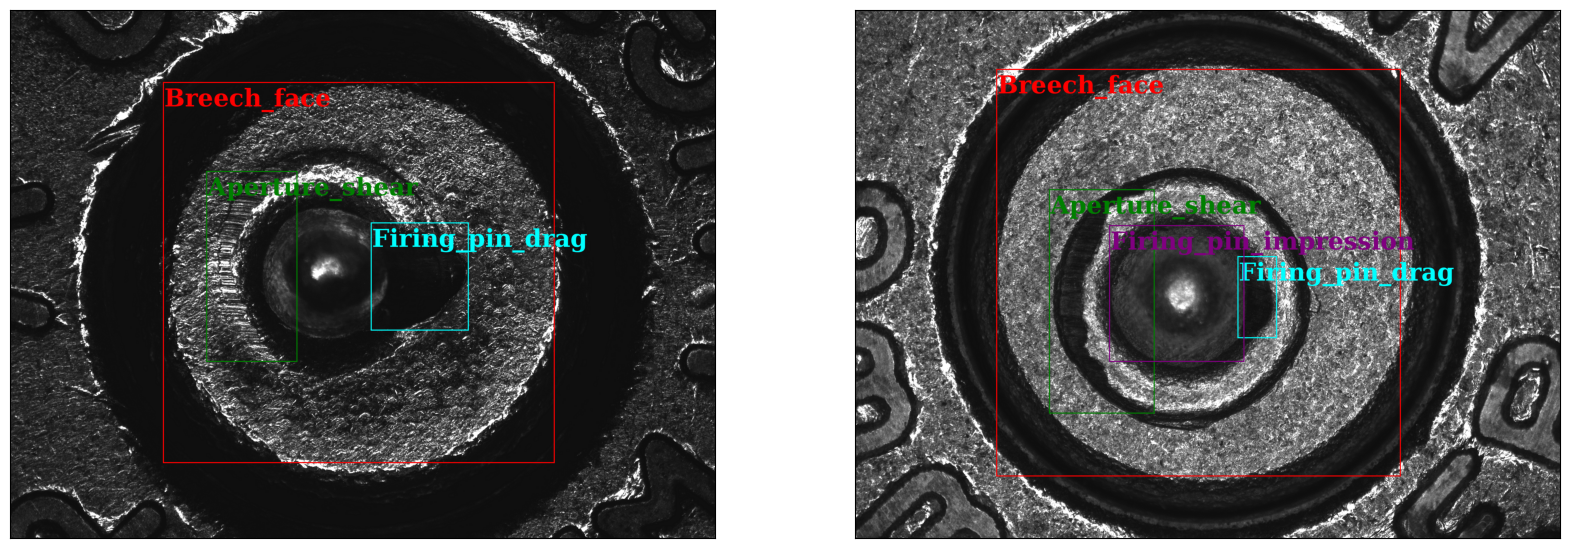

In [18]:
cartridge_with_boxes = [
    draw_bounding_boxes(cartridge_int, boxes=output['boxes'][output['scores'] > score_threshold], labels=label,colors=color, width=4, font_size=90, font='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf')
    for cartridge_int, output, label, color in zip(cartridge_list, outputs, labels, colors)
]
show(cartridge_with_boxes)

In [19]:
normalized_masks = [torch.nn.functional.softmax(output['masks'], dim=1) for output in outputs]

In [20]:
cartridge_output = outputs[0]
cartridge_masks = cartridge_output['masks']
# print(f"shape = {cartridge_masks.shape}, dtype = {cartridge_masks.dtype}, "
#       f"min = {cartridge_masks.min()}, max = {cartridge_masks.max()}")

### Predicted mask overlay on the test image

shape = torch.Size([9, 1, 1944, 2592]), dtype = torch.bool


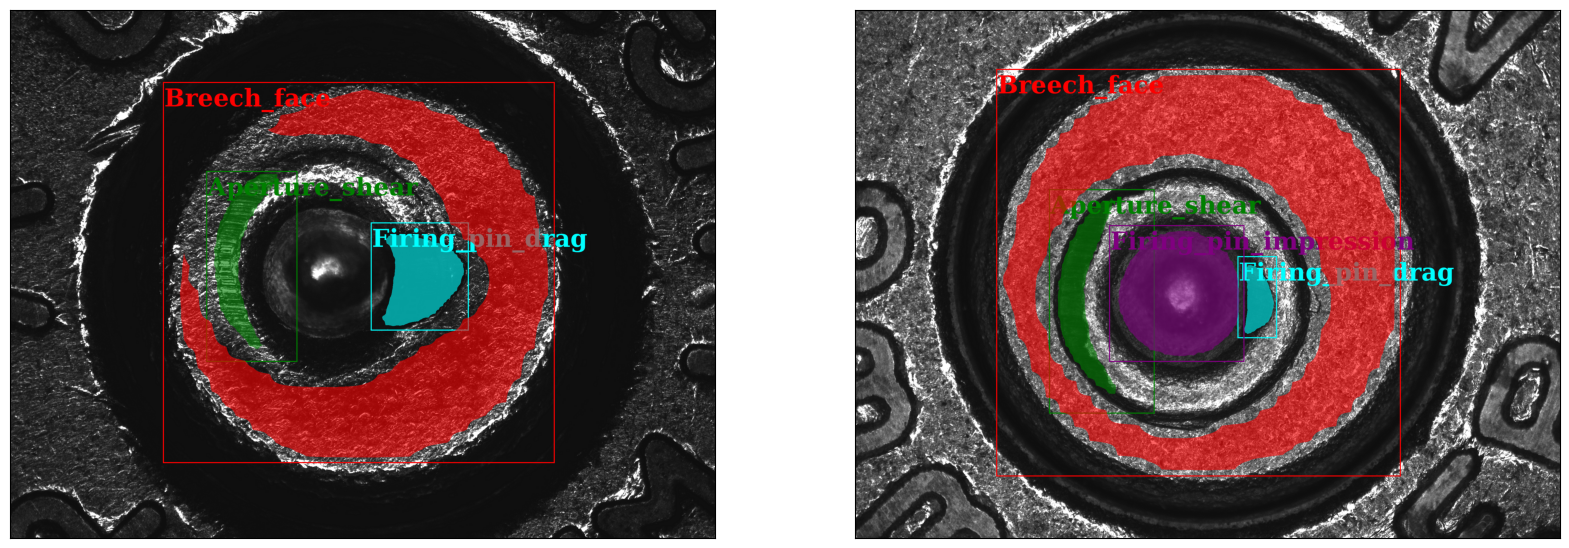

In [21]:
import torchvision.transforms as transforms

proba_threshold = 0.9
cartridge_bool_masks = cartridge_output['masks'] > proba_threshold
print(f"shape = {cartridge_bool_masks.shape}, dtype = {cartridge_bool_masks.dtype}")

boolean_masks = [
    out['masks'][out['scores'] > score_threshold] > proba_threshold
    for out in outputs
]

cartridge_with_masks = [
    draw_segmentation_masks(img, mask.squeeze(1), alpha=0.6, colors=color)
    for img, mask,color in zip(cartridge_with_boxes, boolean_masks, colors)
]

show(cartridge_with_masks)

### Drawing drag arrow

In [29]:
# Here we will draw firing pin drag direction using firing pin impression data and firing pin drag data.
# Center of the Firing pin impression and center of the firing pin drag is considered for the firing drag arrow

import cv2

# Firing pin impression points
point1 = []
for i in range(len(outputs)):
  ans = outputs[i]['boxes'][outputs[i]['labels'] == 3]
  point1.append((int(ans[0][0]/2)+int(ans[0][2]/2), int(ans[0][1]/2)+int(ans[0][3]/2)))

# # Firing pin drag points
point2 = []
for i in range(len(outputs)):
  ans = outputs[i]['boxes'][outputs[i]['labels'] == 2]
  point2.append((int(ans[0][0]/2)+int(ans[0][2]/2), int(ans[0][1]/2)+int(ans[0][3]/2)))

# Drawing an arraow from firing imopression center in the direction of firing drag
# Using mask and bounding box data
def arrowed_line(image, p1, p2):
  cv2.arrowedLine(image, p1, p2, (0,0,255), 20, 7, 0, 0.2)
  cv2.circle(image,p1,70,(0,0,255), 20)
  return image

cartridge_with_arrow = [
    torch.from_numpy(arrowed_line(image.numpy().transpose((1, 2, 0)).astype(np.uint8).copy() , p1, p2).transpose(2,0,1)) for image, p1, p2 in zip(cartridge_with_masks, point1, point2)
]

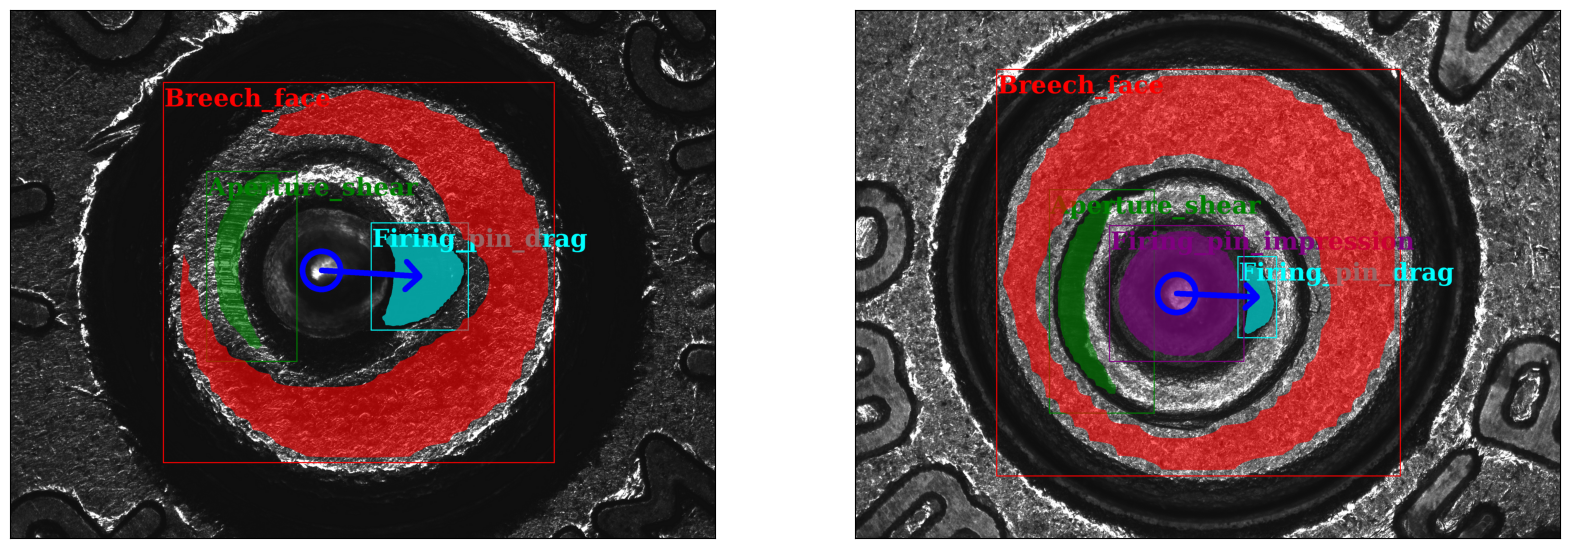

In [30]:
show(cartridge_with_arrow)

In [ ]:
%%shell
jupyter nbconvert --to html Automatic_cartridge_masking.ipynb